This notebook is used to perform survival analysis

In [128]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting, CoxPHFitter, NelsonAalenFitter
from IPython.display import display

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : True,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline

In [129]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 32
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = dropped_na_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/kaplan_meier_comparision/"
print(path_models)
print(path)
print(path_images)

models/32features/dropped_na/
data/32features/dropped_na/
figures/kaplan_meier_comparision/


In [130]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="mixed")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="mixed")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
#display(df)

<Axes: xlabel='duration'>

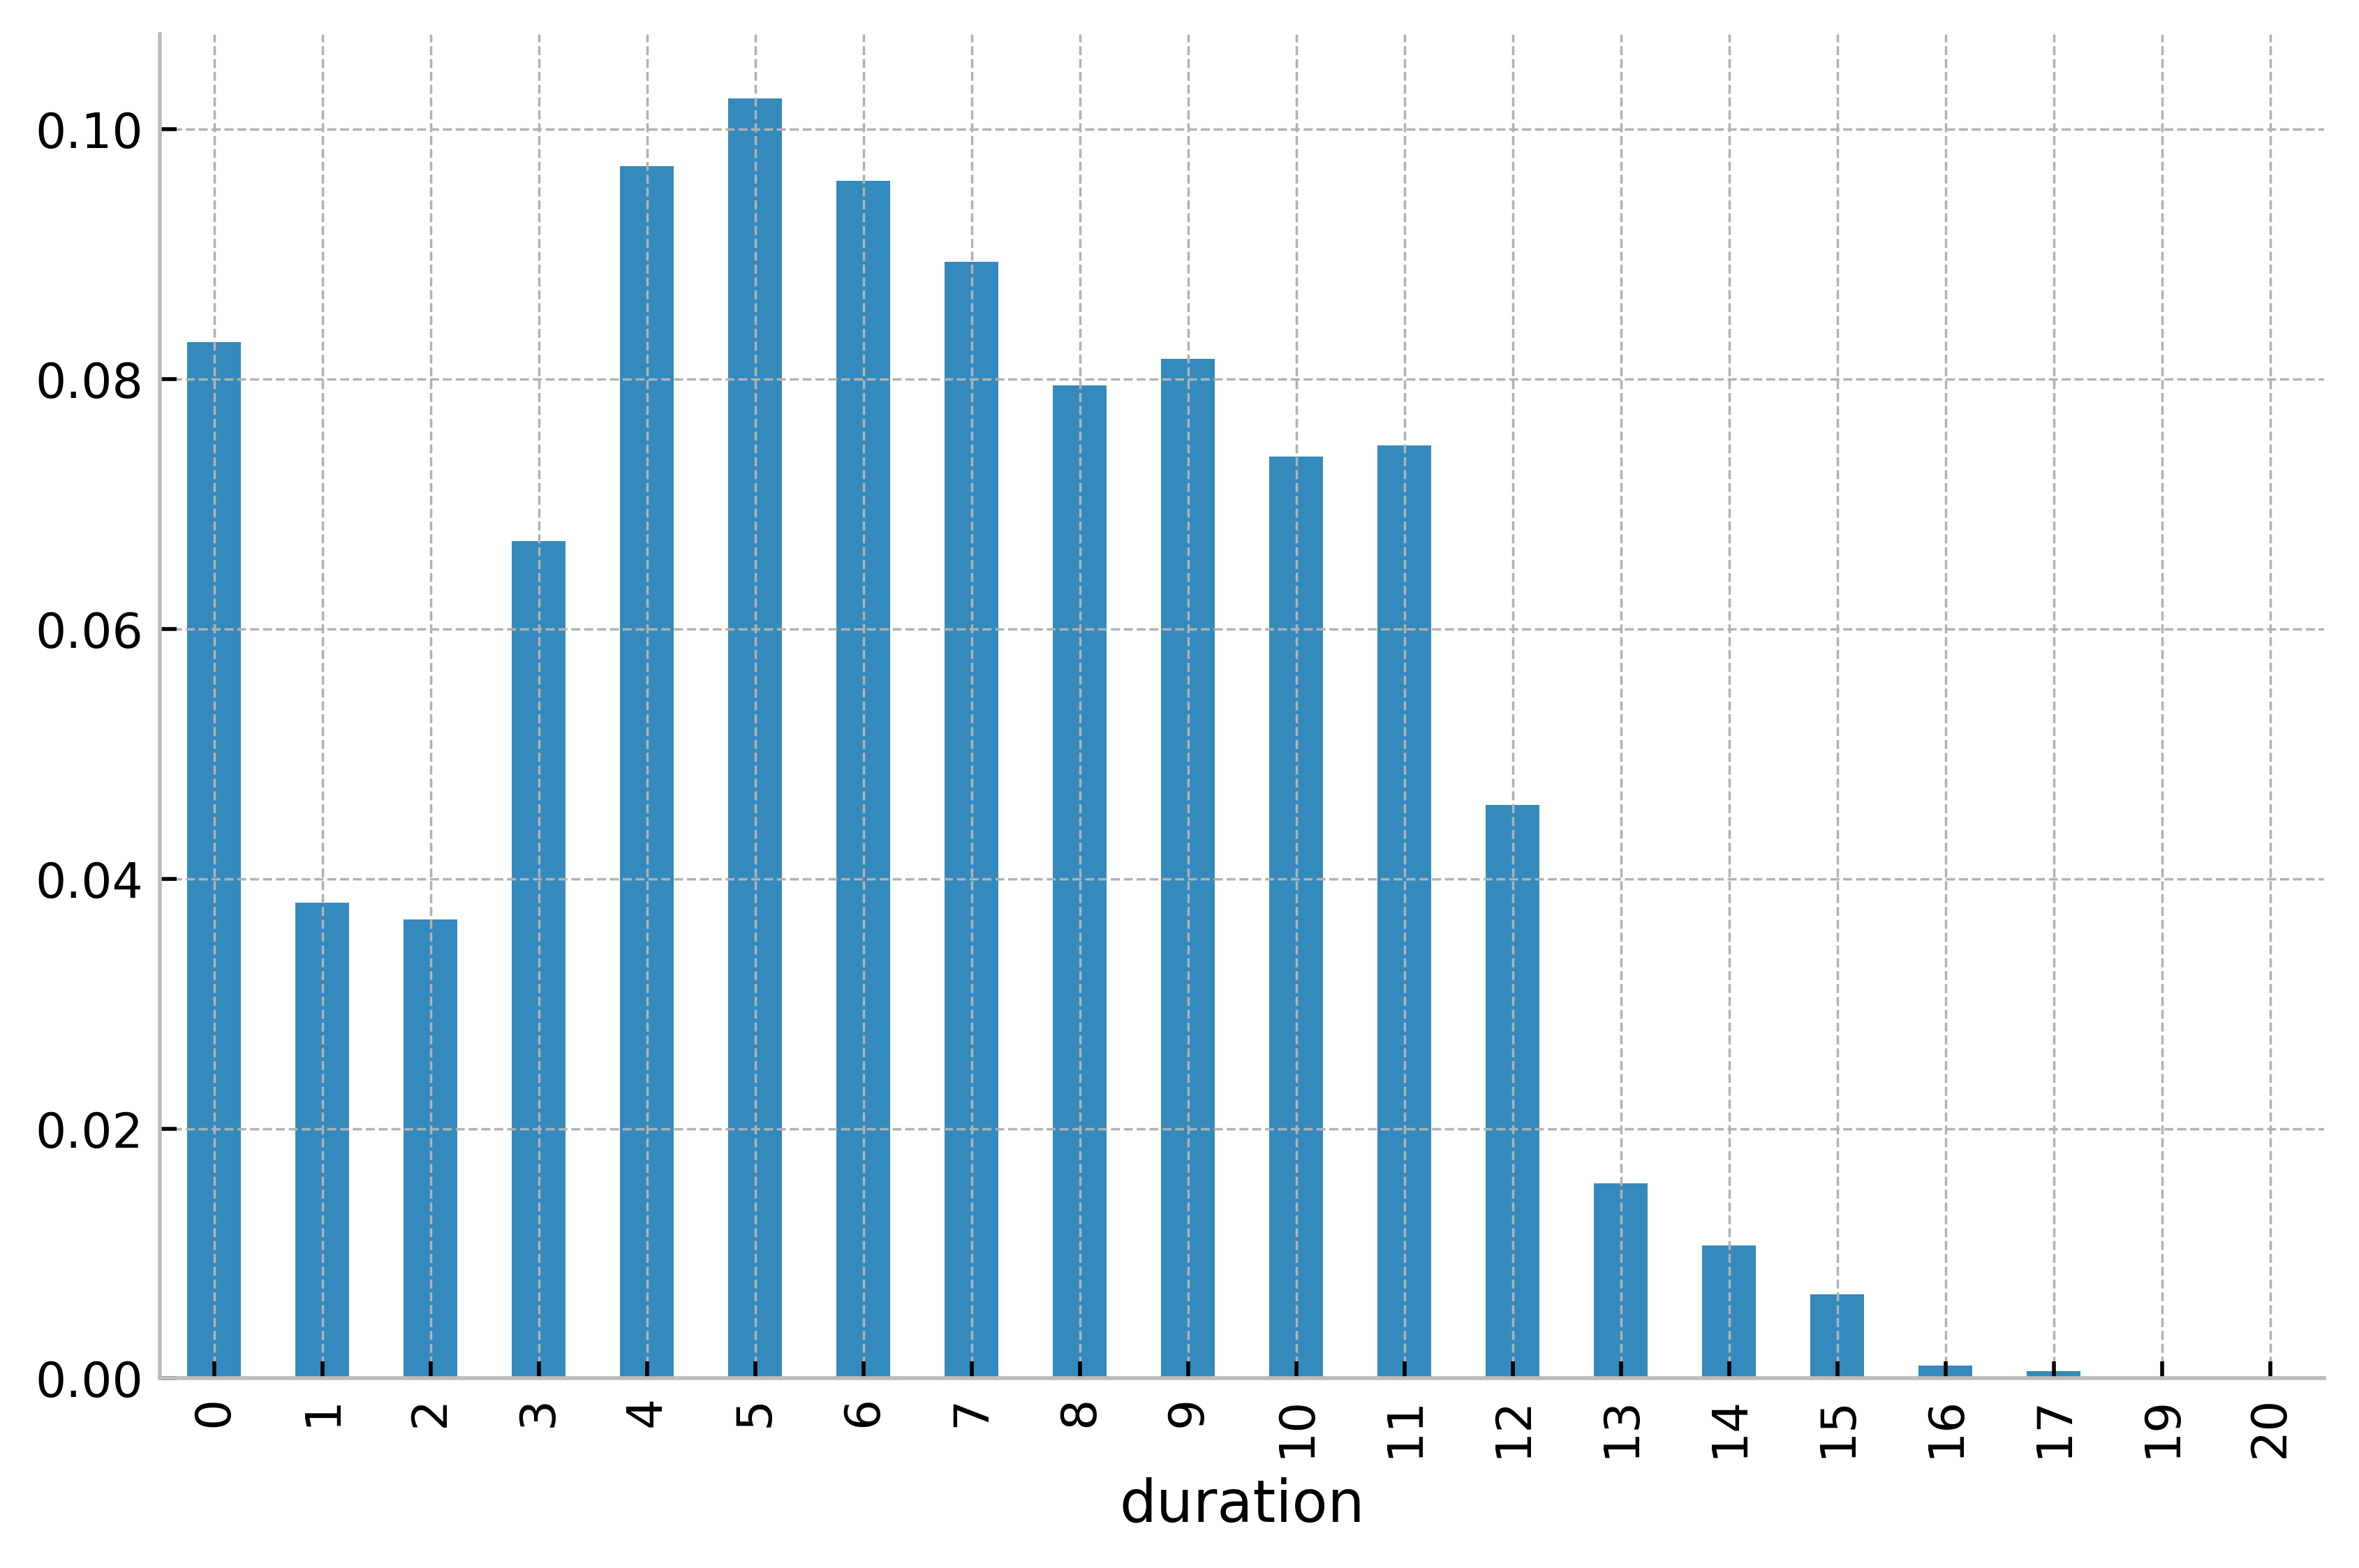

In [131]:
# Birth event: "Data prelievo"
# Death event: "Death7Y"

# Duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = df_diff
df_surv["observed"] = df["CVD Death"]
df_surv["ID"] = np.random.randint(0, 1e6, size=len(df_surv))
#display(df_surv)
# Plot duration
df_surv["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')
# df_surv.to_csv("data/data_surv.csv")

<Axes: xlabel='duration'>

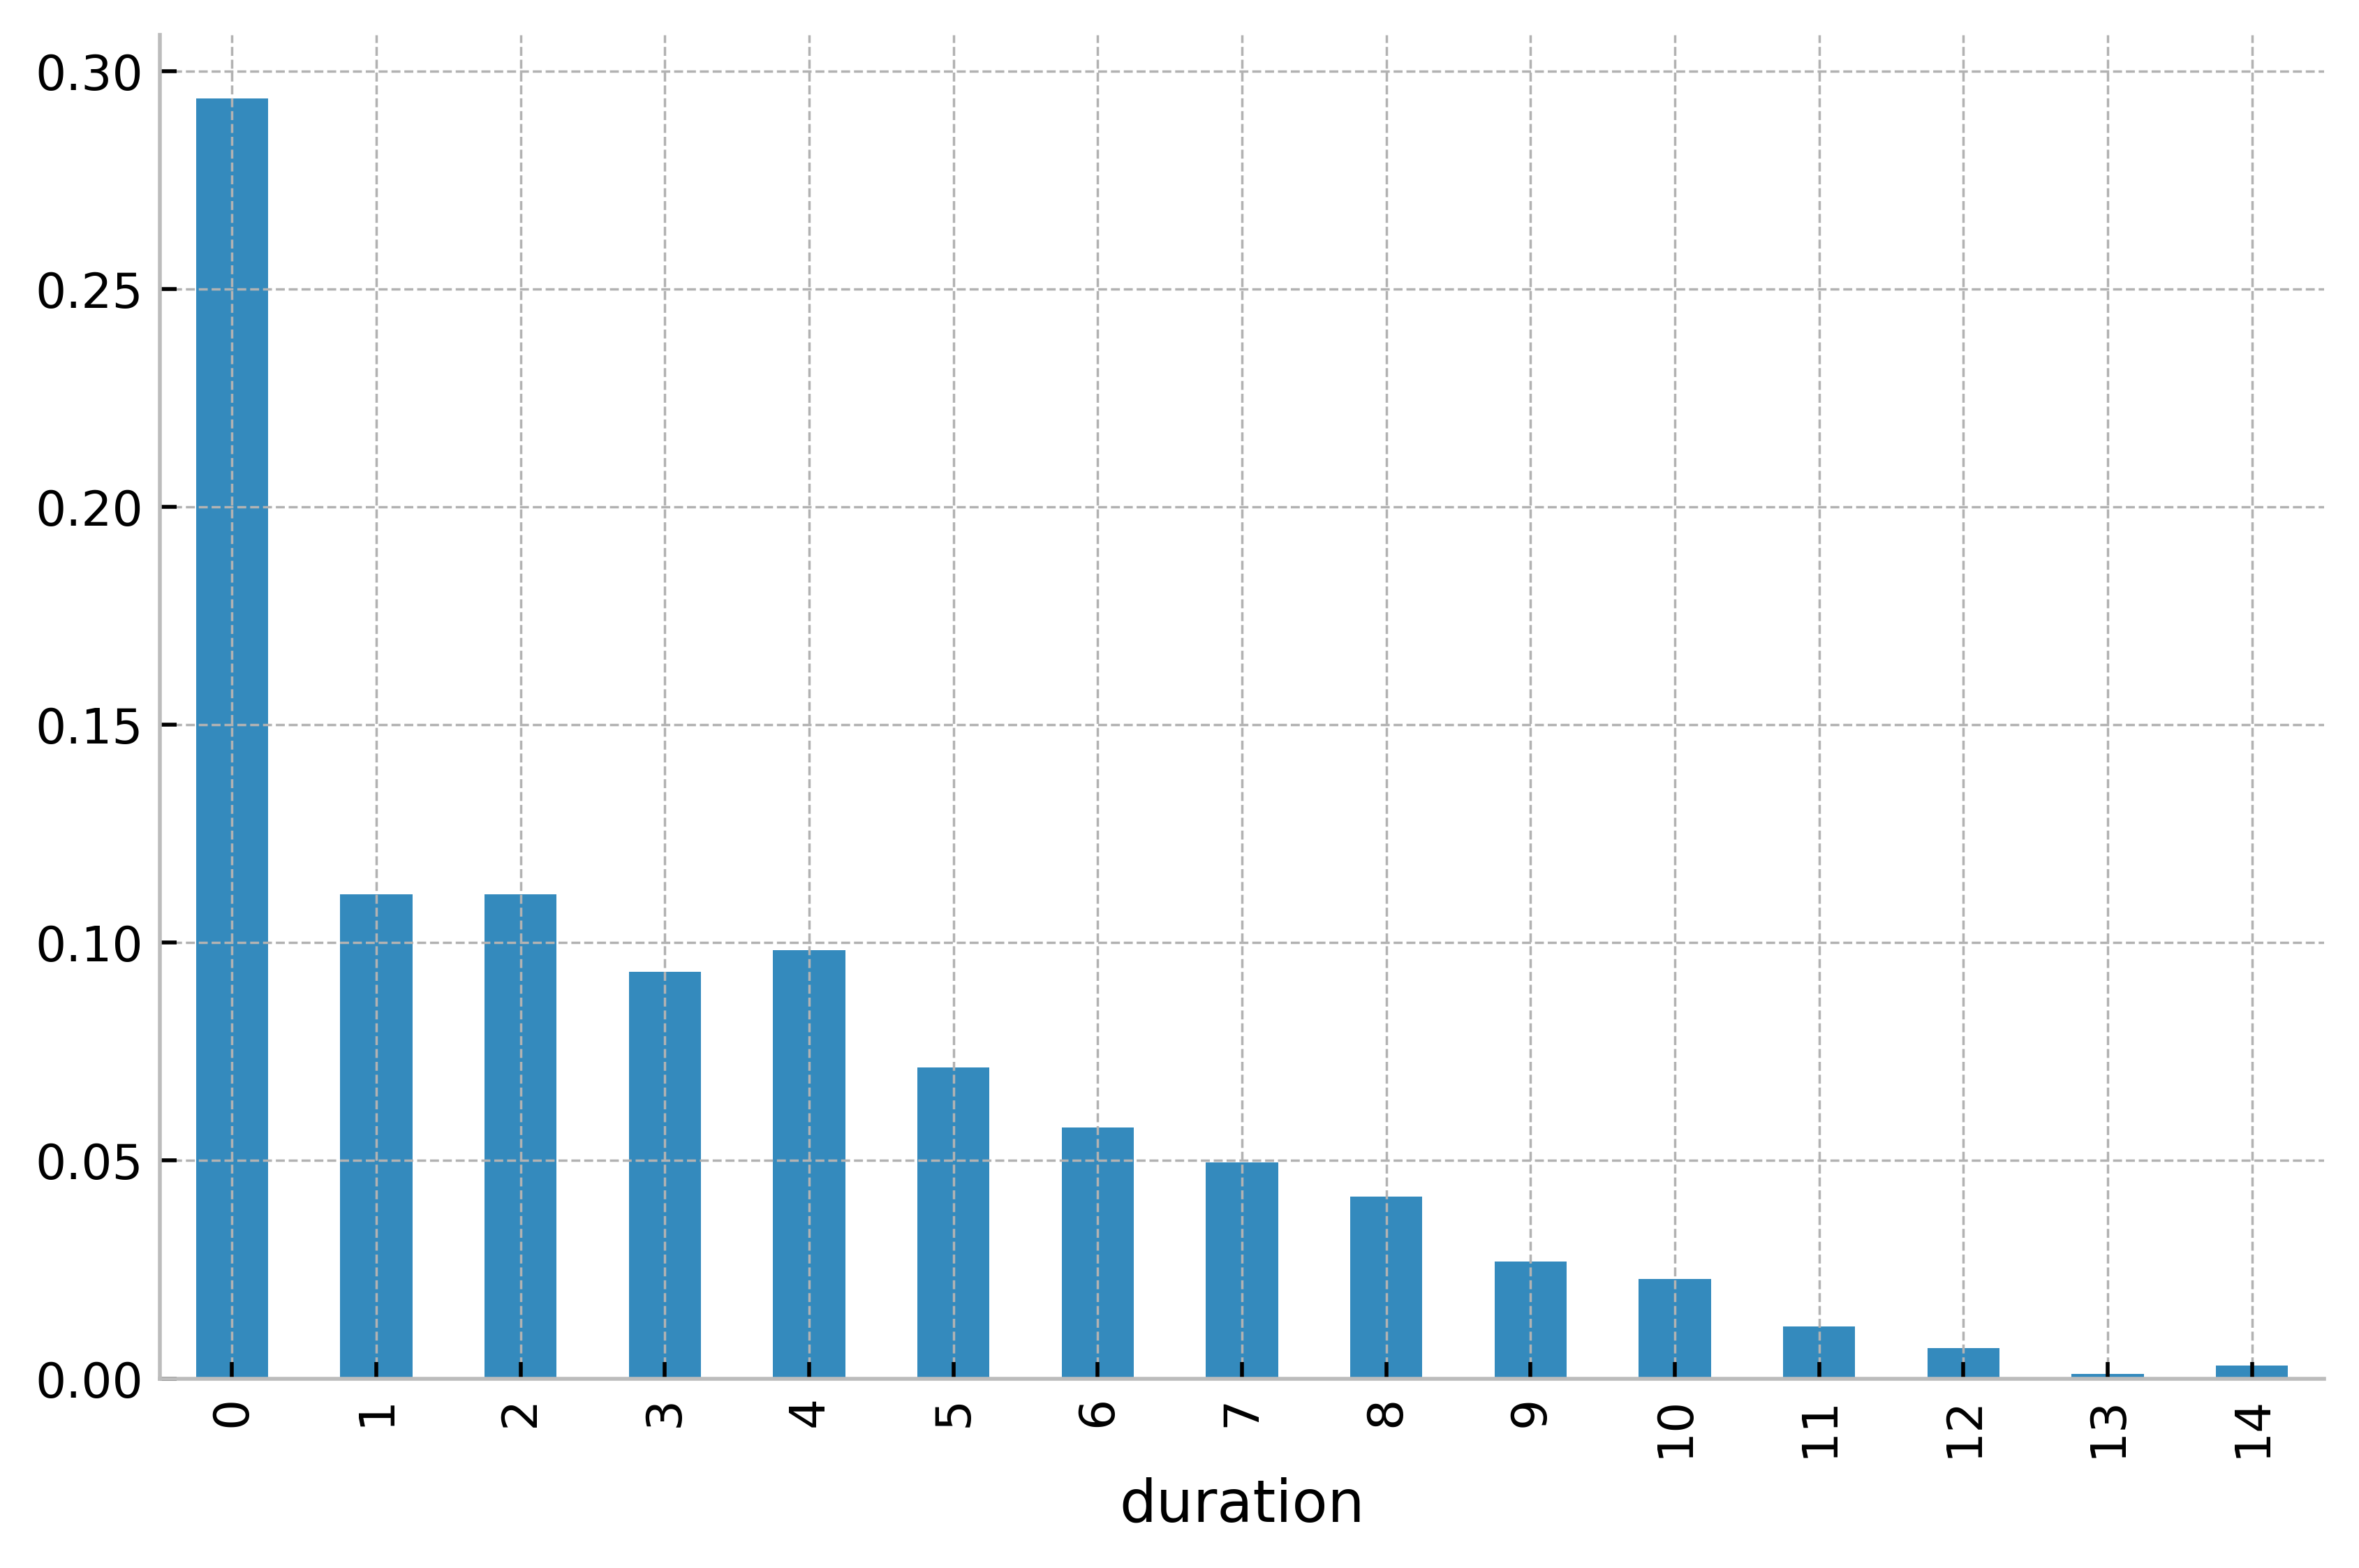

In [132]:
# Data without Right-censoring
#pd.set_option('display.max_rows', 7000)
#display(df_surv[df_surv["observed"]==1])
df_surv[df_surv["observed"]==1]["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')

### Survival Analysis on all the data
The plot indicates the % of CVD patients that survived after n years. 
The probability for surviving more than 7 years is ~86%.

<Axes: title={'center': 'Survival Function of CVD Patients without Right-Censoring'}, xlabel='Years', ylabel='Survive7Y'>

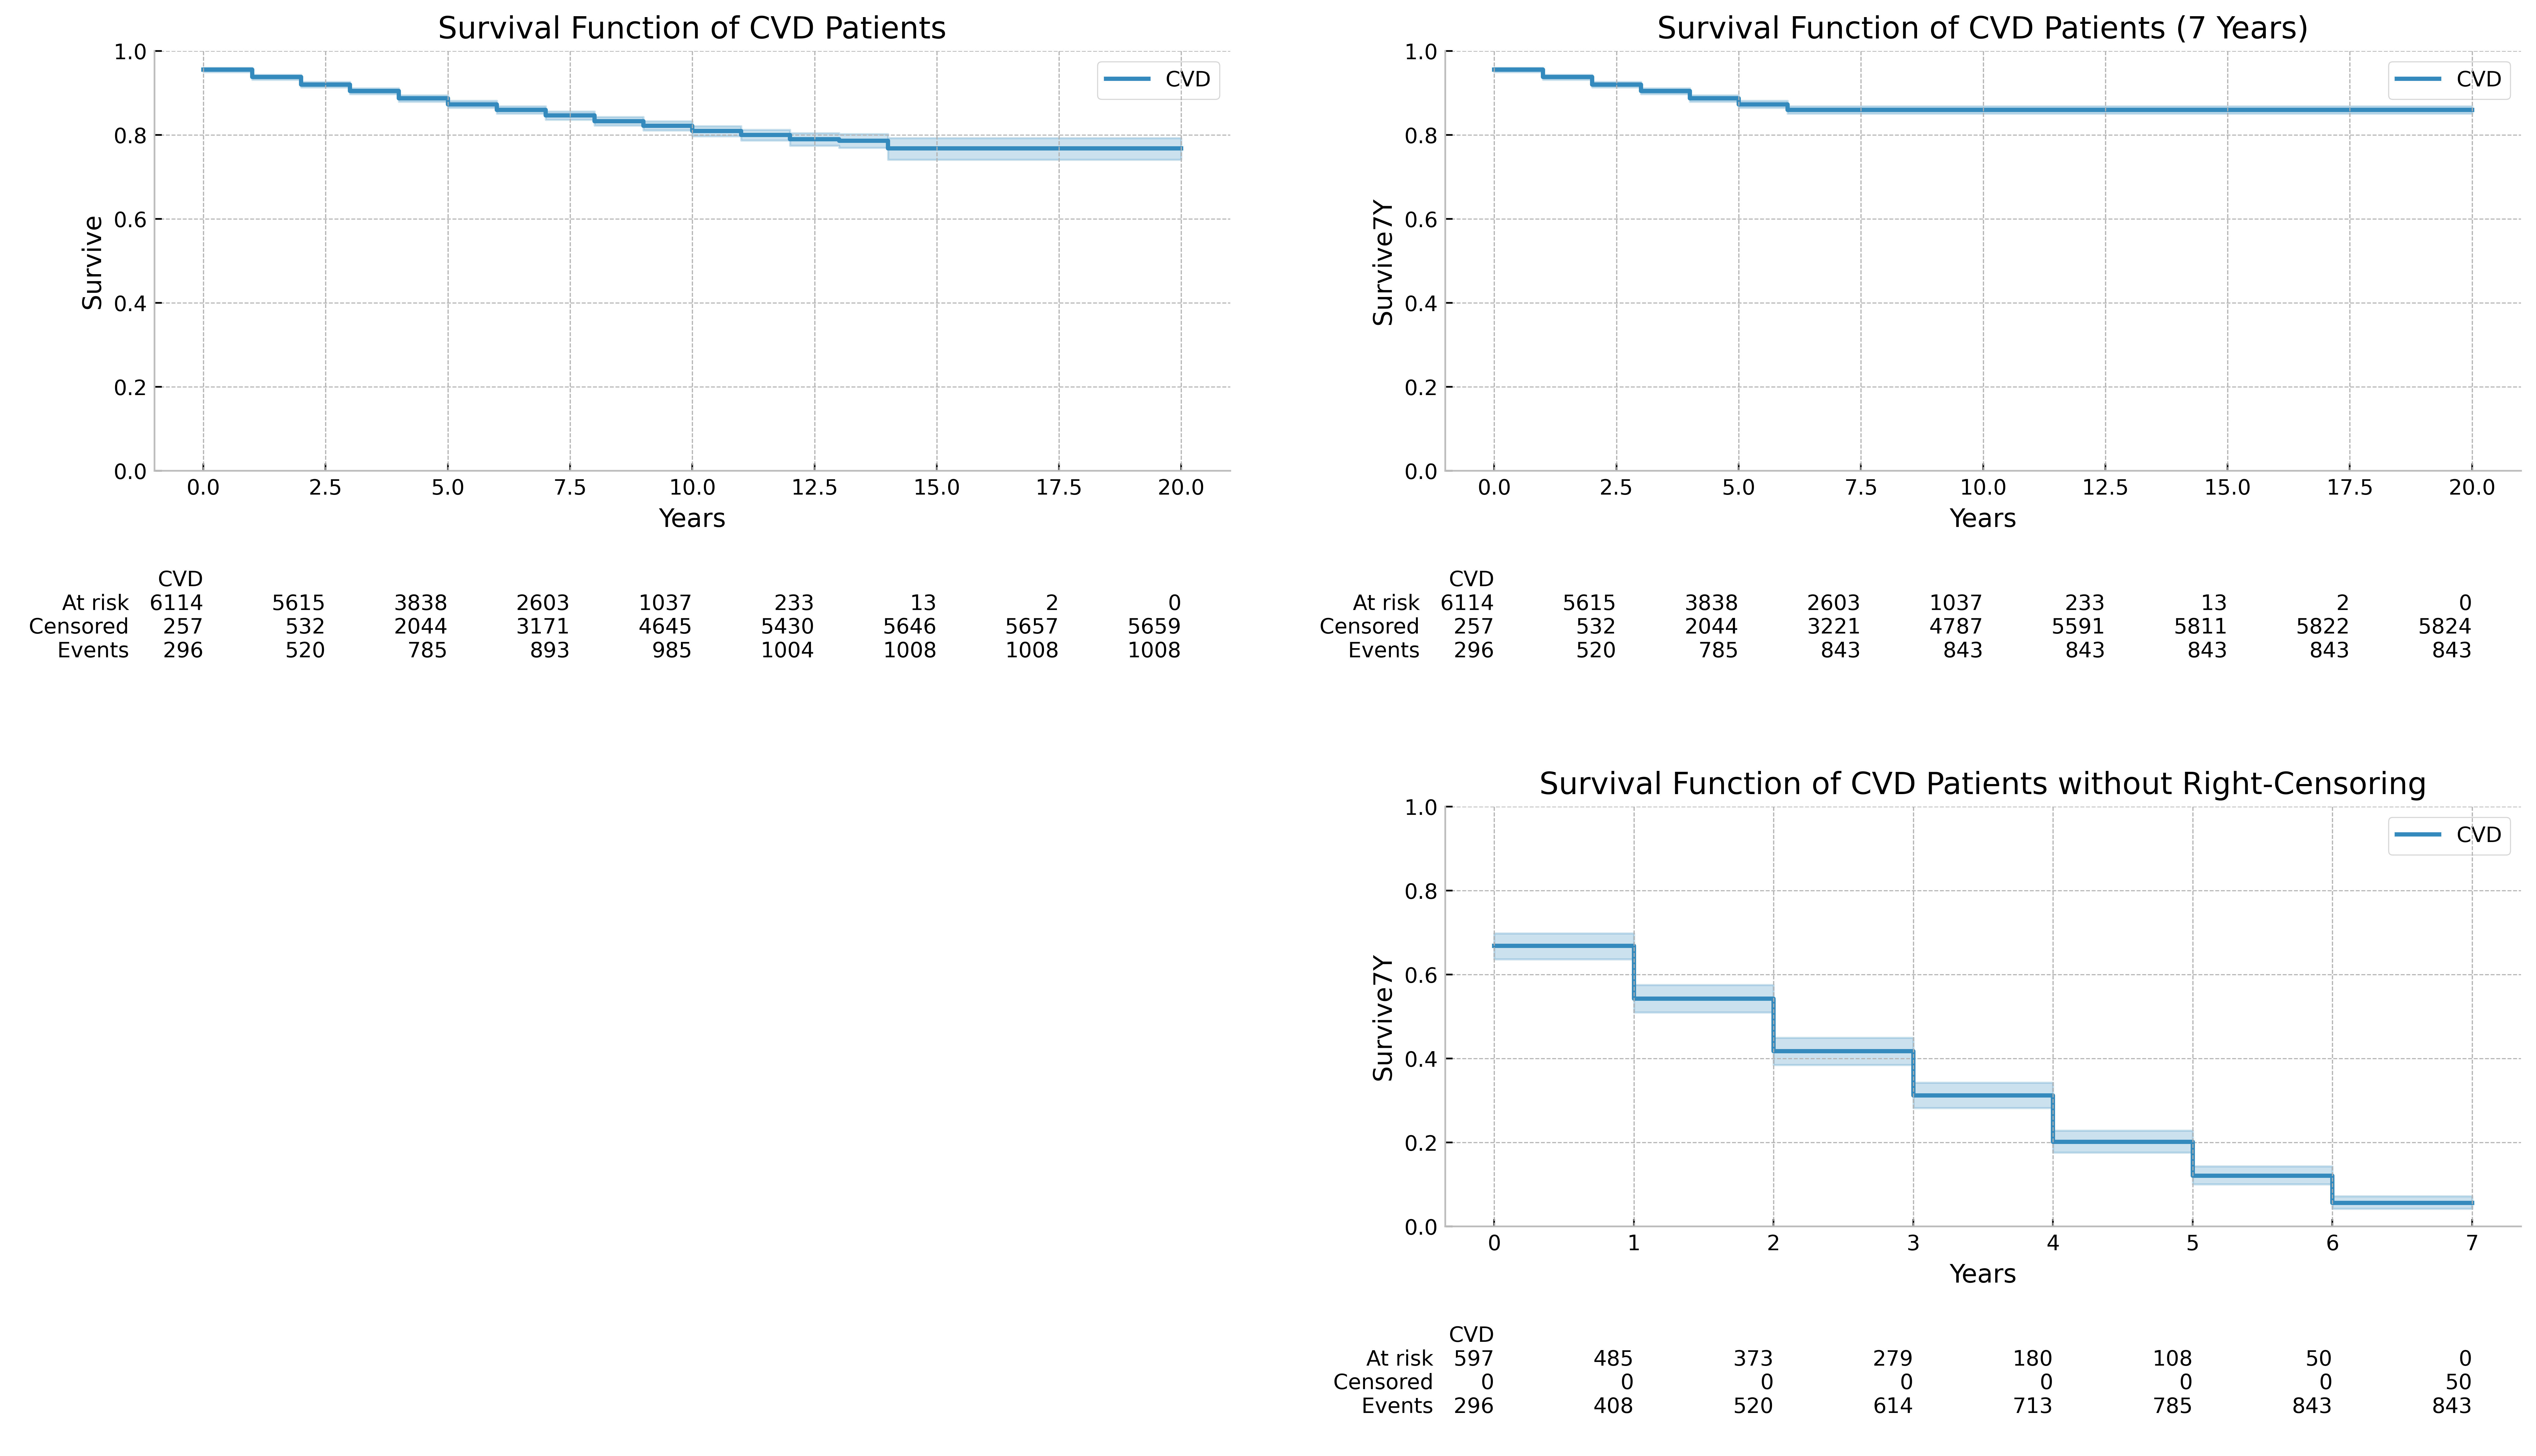

In [133]:
fig = plt.figure(figsize=(20, 10), dpi=500) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)
#display(kmf1.survival_function_at_times(df_surv["duration"].unique()))

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)
#display(kmf2.survival_function_at_times(df_surv["duration"].unique()))


# Without right-censoring
df = df_surv[df_surv["observed"]==1]
df = df[df["duration"]<=7]
plt.subplot2grid(fig_dims, (1, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df["duration"], event_observed=df["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients without Right-Censoring')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

#plt.savefig(f"{path_images}survival_all_par.png")
# kmf.median_survival_time_
# kmf.confidence_interval_

### Survival Analysis Univariate

In [134]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="mixed")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="mixed")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
df["duration"] = df_diff
df["observed"] = df["CVD Death"]

# Remove columns that were not found within the old dataset
to_drop = ['Glycemia', 'Primary Dilated\nCardiomyopathy', 'Normal', 'SindromeX', 'AMI', 'PMI', 'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite', 'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione', 'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'HR', 'Weight', 'Height', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'WmsiBas', 'DimSettoIV', 'DimPP', 'vsx', 'B-Blockers', 'Amiodarone', 'Calcium channel blockers', 'Diuretics', 'Antiplatelet', 'Nitrates', 'ACE-inhibitors', 'Ipolipemizzanti', 'Antidiabetici', 'Cause of death', 'Collected by', 'Suicide', 'CABG ', 'Non Fatal AMI (Follow-Up)', 'Ictus', 'PCI']

#Columns with missing values
drop_columns_missing = ['Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Creatinina']

# Not useful columns
nu_columns = ["Data of death", "Data prelievo", "Follow Up Data",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD"]
df = df.drop(columns = to_drop + drop_columns_missing + nu_columns)
print(len(df.columns)) 
assert len(df.columns) == 30
#display(df)

30


30
0 Gender (Male = 1)
0.1121 0.11205343673508793 2263 4404
1 Age
0.0 4.622764261637793e-73 3076 3591
2 TSH
0.0004 0.0004007937566208717 4507 2160
3 fT3
0.0 5.1158675347401726e-14 3992 2675
4 fT4
0.0 6.432672345161364e-26 3913 2754
5 Euthyroid
0.0 1.6412709165372008e-40 1816 4851
6 Subclinical primary hypothyroidism (SCH)
0.0 2.058404733270715e-08 6295 372
7 Subclinical primary hyperthyroidism
(SCT)
0.5349 0.5349401843222317 6462 205
8 Low T3
0.0 1.8027242533777986e-26 5648 1019
9 Ipotiroidismo
0.0053 0.0052663892232573985 6567 100
10 Ipertiroidismo
0.0049 0.004871816319431292 6546 121
11 Angina
0.0042 0.00416407058208963 3219 3448
12 Previous CABG
0.0 3.5222927809800494e-32 6145 522
13 Previous PCI
0.0371 0.03712980806176076 5781 886
14 Previous Myocardial Infarction
0.0 3.6416233621839285e-29 5015 1652
15 Acute Myocardial Infarction
0.0 1.266222174568919e-09 6054 613
16 Angiography
0.0 8.054073764592256e-06 2509 4158
17 Vessels
0.0346 0.034589406417466 3982 2685
18 Documented resting

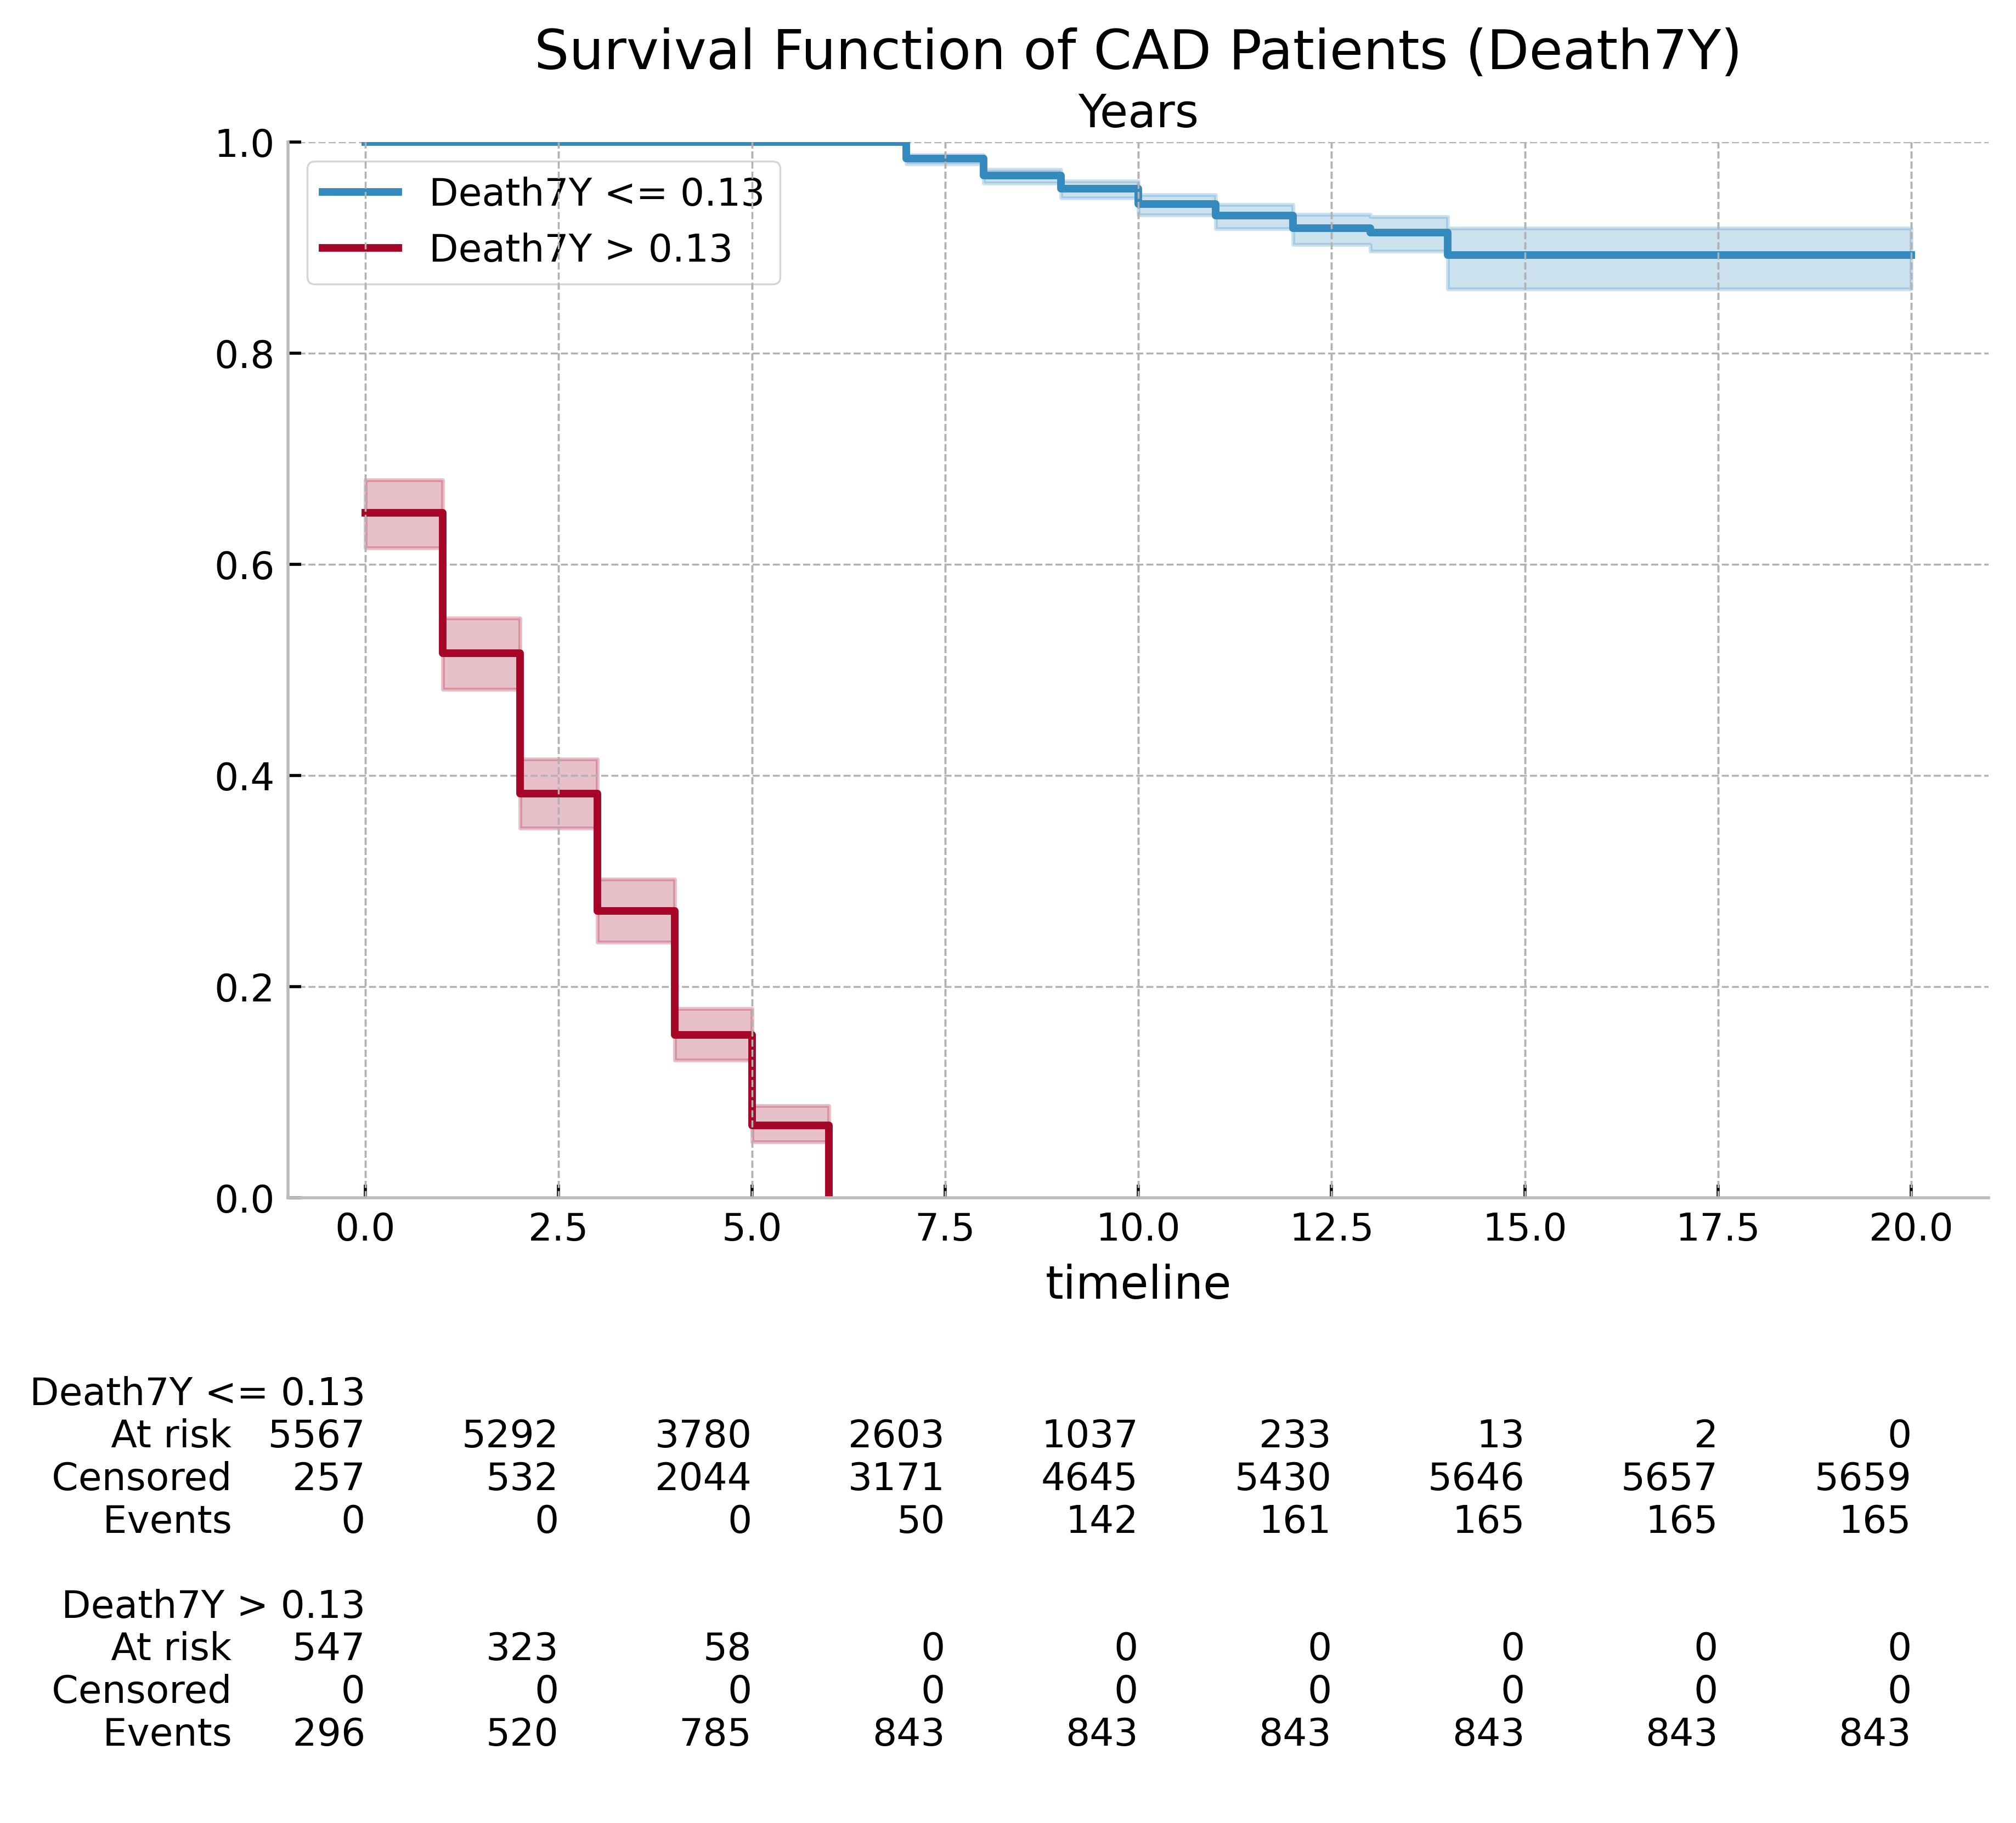

In [135]:
#fig = plt.figure(figsize=(12, 10.5), dpi=400) 
from lifelines.statistics import logrank_test
from contextlib import redirect_stdout
df = df.select_dtypes(exclude=['object','datetime64'])
columns = df.columns
print(len(columns))
for value in enumerate(columns):
    if value[1] == "duration" or value[1] == "observed" or value[1] == "Survive7Y":
        continue
    print(value[0], value[1])
    
    mean = df[value[1]].mean()
    df_under_mean = df[df[value[1]] <= mean]
    df_above_mean = df[df[value[1]] > mean]
    if len(df_under_mean) == 0 or len(df_above_mean) == 0:
        continue
    plt.clf()
    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"{value[1]} <= {round(mean,2)}")
    kmf1.plot_survival_function()
    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"{value[1]} > {round(mean,2)}")
    ax = kmf2.plot_survival_function()
    plotting.add_at_risk_counts(kmf1, kmf2)
    plt.title(f'Survival Function of CAD Patients ({value[1]})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    #plt.legend(loc="lower left")
    ax.get_figure().savefig(f"{path_images}{value[1]}.png")
    results = logrank_test(df_under_mean["duration"], df_above_mean["duration"], df_under_mean["observed"], df_above_mean["observed"])
    print(round(results.p_value,4), results.p_value, len(df_under_mean.index), len(df_above_mean.index))

In [136]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
#df_test_pred["ModelOutput"].sort_values().median()

FileNotFoundError: [Errno 2] No such file or directory: 'data/32features/dropped_na/extra_test_output.csv'

### Survival Analysis Model 

In [ ]:
from lifelines.statistics import logrank_test
def plot_kmf(df_pred, threshold, variable):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]
    print(df_pred_under["ModelOutput"].mean(),df_pred_above["ModelOutput"].mean())

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()
    print(kmf1.survival_function_)

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")
    print(kmf2.survival_function_)

    plt.title(f'Survival Function of IHD Patients ({variable})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")

    results = logrank_test(df_pred_under["duration"], df_pred_above["duration"], df_pred_under["observed"], df_pred_above["observed"])
    print(results)
    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

## Plot the survival function for patients under and over the threshold of the ModelOutput

In [ ]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
display(df_test_pred), len(df_test_pred.index)

,Death7Y,duration,observed,ID,ModelOutput
Number,,,,,
6,0,2,0,558655,0.714614
13,0,7,0,223797,0.963562
16,0,7,0,662268,0.679587
17,0,12,0,962831,0.788389
22,1,3,1,690383,0.059735
...,...,...,...,...,...
8051,0,0,0,582935,0.939591
8055,0,2,0,671903,0.742455
8059,1,0,1,189902,0.635653


(None, 1334)

0.5811328334643975 0.9153509661322152
           <= 0.75
timeline          
0.0       0.869565
1.0       0.808968
2.0       0.771487
3.0       0.745335
4.0       0.684710
5.0       0.649496
6.0       0.616310
7.0       0.576731
8.0       0.522450
9.0       0.513121
10.0      0.488090
11.0      0.471821
12.0      0.416312
13.0      0.416312
14.0      0.416312
15.0      0.416312
16.0      0.416312
17.0      0.416312
            > 0.75
timeline          
0.0       0.985844
1.0       0.982701
2.0       0.968755
3.0       0.962179
4.0       0.956320
5.0       0.951094
6.0       0.942021
7.0       0.931131
8.0       0.918078
9.0       0.901436
10.0      0.890073
11.0      0.866650
12.0      0.866650
13.0      0.866650
14.0      0.866650
15.0      0.866650
17.0      0.866650
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         248.46 <0.005   

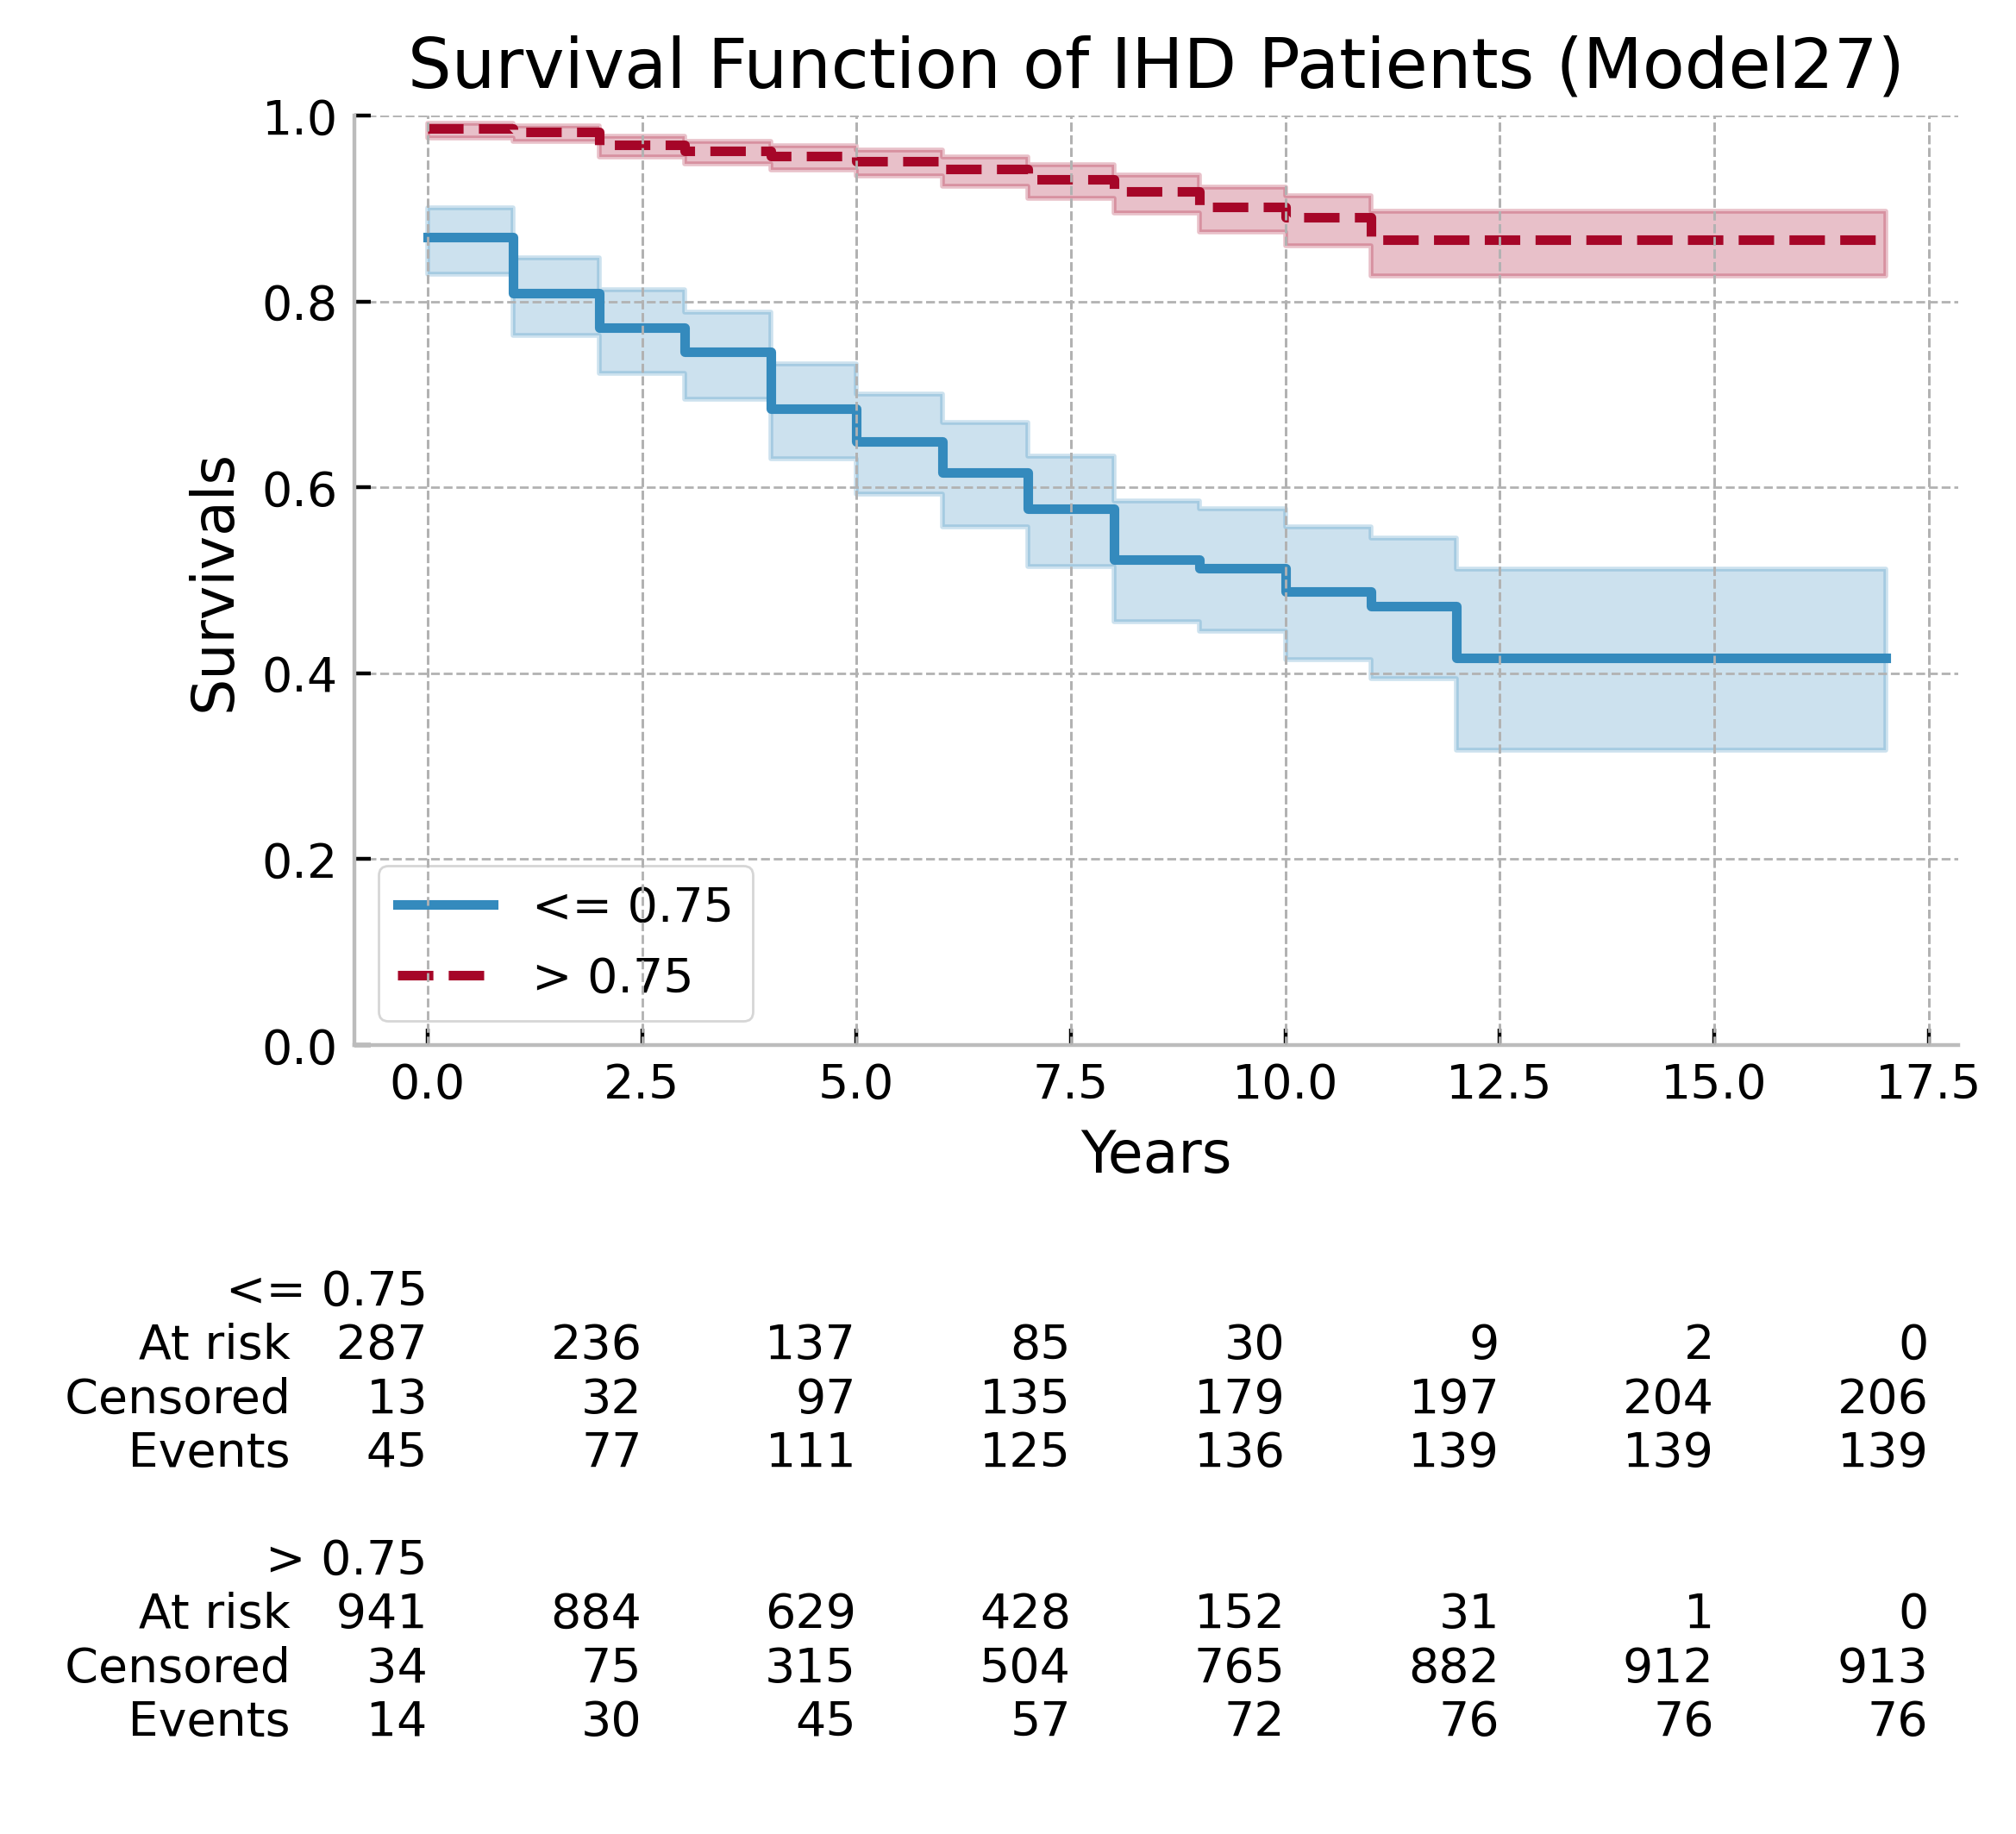

In [ ]:
# Plots
fig = plt.figure(figsize=(6, 3.5), dpi=400) 
fig_dims = (1, 1)
fig.subplots_adjust(hspace=1, wspace=0.2)
threshold = 0.75 # median of ModelOutput is 0.911
plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test_pred, threshold=threshold, variable="Model27")
plt.savefig(f"{path_images}survival_model_27.png", bbox_inches="tight", dpi=400)
#plt.savefig(f"{path_images}survival_model_27.tiff", format="tiff", bbox_inches="tight", dpi=400)

## COX Regression and p-value 


In [ ]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')

# Model 27 all features
df_test_pred = df.drop(list(set(df.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
df_test_pred = df_test_pred.drop(["Survive7Y", "Death7Y"],axis=1)


In [ ]:
df_test_pred.columns, len(df_test_pred.columns) 

(Index(['Gender (Male = 1)', 'Age', 'TSH', 'fT3', 'fT4', 'Euthyroid',
        'Subclinical primary hypothyroidism (SCH)',
        'Subclinical primary hyperthyroidism\n(SCT)', 'Low T3', 'Ipotiroidismo',
        'Ipertiroidismo', 'Angina', 'Previous CABG', 'Previous PCI',
        'Previous Myocardial Infarction', 'Acute Myocardial Infarction',
        'Angiography', 'Vessels', 'Documented resting \nor exertional ischemia',
        'Post-ischemic Dilated\nCardiomyopathy', 'Smoke\nHistory of smoke',
        'Diabetes\nHistory of diabetes',
        'Hypertension\nHistory of hypertension',
        'Dyslipidemia\nHystory of dyslipidemia', 'Atrial Fibrillation', 'fe',
        'duration', 'observed', 'ModelOutput'],
       dtype='object'),
 29)

Univariate

In [ ]:
#i = 17
for key in range(0,26):
    cph = CoxPHFitter()
    cph.fit(df_test_pred.loc[:, [df_test_pred.columns[key], "duration", "observed"]], duration_col='duration', event_col='observed')
    #cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
    print(f"{df_test_pred.columns[key]}: {cph.concordance_index_} {cph.summary['p']}")
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
print(f"ML Indicator (27 variables): {cph.concordance_index_}")

Gender (Male = 1): 0.5134365380875817 covariate
Gender (Male = 1)    0.599028
Name: p, dtype: float64
Age: 0.7556025099244461 covariate
Age    7.704975e-33
Name: p, dtype: float64
TSH: 0.5353106339788374 covariate
TSH    0.171129
Name: p, dtype: float64
fT3: 0.608647192460741 covariate
fT3    0.11064
Name: p, dtype: float64
fT4: 0.5957086552553321 covariate
fT4    0.017625
Name: p, dtype: float64
Euthyroid: 0.6198284979819108 covariate
Euthyroid    1.146705e-12
Name: p, dtype: float64
Subclinical primary hypothyroidism (SCH): 0.5222321822398657 covariate
Subclinical primary hypothyroidism (SCH)    0.004367
Name: p, dtype: float64
Subclinical primary hyperthyroidism
(SCT): 0.5069056122327988 covariate
Subclinical primary hyperthyroidism\n(SCT)    0.658462
Name: p, dtype: float64
Low T3: 0.5790920258201601 covariate
Low T3    1.306322e-08
Name: p, dtype: float64
Ipotiroidismo: 0.499483027655649 covariate
Ipotiroidismo    0.51343
Name: p, dtype: float64
Ipertiroidismo: 0.5121156500334372 

Multivariate Top 27 variables + Model 27

In [ ]:
# cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_test_pred, duration_col='duration', event_col='observed')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1334 total observations, 1119 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1334
number of events observed = 215
   partial log-likelihood = -1308.94
         time fit was run = 2025-09-18 07:09:57 UTC

---
                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                    
Gender (Male = 1)                           -0.01      0.99      0.12           -0.25            0.22                0.78                1.25
Age                                          0.03      1.03      0.00            0.02            0.04                1.02                1.04
TSH                                          0.01      1.01      0.02           -0.03            0.04                0.97                1.04
fT3                                         -0.01      0.99      0.04           -0.10            0.07                0.91                1.07
fT4                                          0.00      1.00      0.01           -0.02            0.03                0.98                1.03
Euthyroid                                   -0.30      0.74      0.15           -0.60           -0.01                0.55                0.99
Subclinical primary hypothyroidism (SCH)     0.17      1.19      0.22           -0.26            0.61                0.77                1.83
Subclinical primary hyperthyroidism\n(SCT)   0.19      1.21      0.34           -0.47            0.85                0.62                2.35
Low T3                                       0.28      1.32      0.17           -0.05            0.61                0.95                1.84
Ipotiroidismo                               -0.10      0.91      0.55           -1.18            0.98                0.31                2.68
Ipertiroidismo                               0.50      1.64      0.39           -0.27            1.26                0.76                3.53
Angina                                      -0.13      0.88      0.11           -0.35            0.10                0.70                1.10
Previous CABG                                0.12      1.12      0.18           -0.24            0.48                0.79                1.61
Previous PCI                                 0.19      1.21      0.17           -0.13            0.51                0.87                1.67
Previous Myocardial Infarction               0.40      1.49      0.13            0.14            0.66                1.15                1.94
Acute Myocardial Infarction                  0.47      1.60      0.18            0.12            0.81                1.13                2.26
Angiography                                 -0.20      0.82      0.13           -0.45            0.04                0.64                1.04
Vessels                                      0.06      1.06      0.06           -0.05            0.17                0.96                1.19
Documented resting \nor exertional ischemia -0.16      0.85      0.13           -0.41            0.08                0.67                1.09
Post-ischemic Dilated\nCardiomyopathy        0.11      1.11      0.17           -0.23            0.45                0.79                1.57
Smoke\nHistory of smoke                     -0.13      0.88      0.12           -0.36            0.10                0.70                1.10
Diabetes\nHistory of diabetes                0.20      1.23      0.13           -0.04            0.45                0.96                1.57
Hypertension\nHistory of hypertension       -0.03      0.97      0.11           -0.25            0.19                0.78                1.20
Dyslipidemia\nHyst

Multivariate all variables

In [ ]:
df_feat = df_test_pred.drop(columns=["ModelOutput"])
# cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_feat, duration_col='duration', event_col='observed')
cph.print_summary()
cph.concordance_index_


<lifelines.CoxPHFitter: fitted with 1334 total observations, 1119 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1334
number of events observed = 215
   partial log-likelihood = -1324.28
         time fit was run = 2025-09-18 07:09:57 UTC

---
                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                    
Gender (Male = 1)                           -0.01      0.99      0.12           -0.24            0.23                0.79                1.25
Age                                          0.03      1.03      0.00            0.02            0.04                1.02                1.04
TSH                                          0.01      1.01      0.02           -0.02            0.04                0.98                1.04
fT3                                         -0.01      0.99      0.04           -0.10            0.07                0.91                1.07
fT4                                          0.00      1.00      0.01           -0.02            0.03                0.98                1.03
Euthyroid                                   -0.32      0.73      0.15           -0.61           -0.03                0.54                0.97
Subclinical primary hypothyroidism (SCH)     0.25      1.28      0.22           -0.18            0.68                0.83                1.98
Subclinical primary hyperthyroidism\n(SCT)   0.16      1.17      0.34           -0.50            0.82                0.60                2.26
Low T3                                       0.29      1.33      0.17           -0.04            0.61                0.96                1.84
Ipotiroidismo                               -0.16      0.86      0.55           -1.23            0.92                0.29                2.50
Ipertiroidismo                               0.47      1.60      0.39           -0.29            1.23                0.75                3.41
Angina                                      -0.12      0.89      0.11           -0.34            0.11                0.71                1.11
Previous CABG                                0.26      1.30      0.18           -0.10            0.62                0.91                1.85
Previous PCI                                 0.19      1.21      0.17           -0.14            0.51                0.87                1.67
Previous Myocardial Infarction               0.48      1.61      0.13            0.22            0.73                1.24                2.08
Acute Myocardial Infarction                  0.55      1.74      0.18            0.21            0.90                1.23                2.46
Angiography                                 -0.30      0.74      0.12           -0.54           -0.06                0.58                0.95
Vessels                                      0.09      1.09      0.06           -0.02            0.20                0.98                1.22
Documented resting \nor exertional ischemia -0.20      0.82      0.12           -0.44            0.04                0.64                1.04
Post-ischemic Dilated\nCardiomyopathy        0.24      1.27      0.17           -0.10            0.58                0.91                1.79
Smoke\nHistory of smoke                     -0.15      0.86      0.12           -0.38            0.07                0.69                1.08
Diabetes\nHistory of diabetes                0.27      1.31      0.13            0.03            0.52                1.03                1.68
Hypertension\nHistory of hypertension       -0.07      0.93      0.11           -0.29            0.15                0.75                1.16
Dyslipidemia\nHyst

np.float64(0.8541616273720256)